## Project Criteria

1. Can you describe how our email list(s) are growing?

1. Can you describe how our email list(s) are churning?

1. What is the average lifetime of an email user (how long do they receive at least one of our email series)? Does that vary by referrer?

1. What factors correlate the most to churn? 
Due date?
Source?
Anything else?

1. How would you describe our worst cohort?

1. How would you describe our best cohort?

1. Are there any recommendations you would make based on this data? What are things we could try to provide a better user experience?


Connect to mysql

In [1]:
import mysql.connector
import pandas as pd 
import matplotlib.pyplot as plt  
from datetime import datetime

# Use ggplot as plt style
plt.style.use('ggplot') 

In [205]:
cnx = mysql.connector.connect(user='root', password='8xIt7ASAOzIh',
                              host='dw-sandbox-rds.ccia3ag00jrs.us-west-2.rds.amazonaws.com',
                              database='dw')

Read first 3 data 

In [207]:
query = """
    SELECT * 
    FROM dim_users 
    ORDER BY created_at DESC
    LIMIT 3
    """
df = pd.read_sql_query(query, con = cnx)

In [208]:
df

,id,created_at,email,original_arrival_date,referrer,registry_created_at,source,updated_at,baby_registry_101_subscribed_at,newsletter_subscribed_at,...,sponsored_delivered,sponsored_open,sponsored_click,sponsored_last_open_at,sponsored_unsubscribe_at,transactional_delivered,transactional_open,transactional_click,transactional_last_open_at,is_active
0,1575641,2017-10-18 08:58:48,user-1575641@babylist.com,None,None,None,registry,2017-10-18 08:58:24,None,None,...,0,0,0,None,None,0,0,0,None,NaN
1,1575640,2017-10-18 08:57:34,user-1575640@babylist.com,None,None,None,checklist,2017-10-18 08:58:24,None,None,...,0,0,0,None,None,0,0,0,None,1.0
2,1575639,2017-10-18 08:51:31,user-1575639@babylist.com,None,None,None,registry,2017-10-18 08:58:24,None,None,...,0,0,0,None,None,0,0,0,None,1.0


In [196]:
# Check column names - 37 columns
df.columns.values.tolist()

[u'id',
 u'created_at',
 u'email',
 u'original_arrival_date',
 u'referrer',
 u'registry_created_at',
 u'source',
 u'updated_at',
 u'baby_registry_101_subscribed_at',
 u'newsletter_subscribed_at',
 u'pregnancy_weekly_subscribed_at',
 u'sponsored_subscribed_at',
 u'baby_registry_101_delivered',
 u'baby_registry_101_open',
 u'baby_registry_101_click',
 u'baby_registry_101_last_open_at',
 u'baby_registry_101_unsubscribe_at',
 u'newsletter_delivered',
 u'newsletter_open',
 u'newsletter_click',
 u'newsletter_last_open_at',
 u'newsletter_unsubscribe_at',
 u'pregnancy_weekly_delivered',
 u'pregnancy_weekly_open',
 u'pregnancy_weekly_click',
 u'pregnancy_weekly_last_open_at',
 u'pregnancy_weekly_unsubscribe_at',
 u'sponsored_delivered',
 u'sponsored_open',
 u'sponsored_click',
 u'sponsored_last_open_at',
 u'sponsored_unsubscribe_at',
 u'transactional_delivered',
 u'transactional_open',
 u'transactional_click',
 u'transactional_last_open_at',
 u'is_active']

### Exploratory data analysis

First, we do an exploratory data analysis and see if there's any interesting things or data needed to be cleaned up. 

##### [Descriptive statistics]

In [ ]:
# define a function for round each column
def round0(data):
    return (round(data, 0))
# Print out decsciption of each numeric column and applymap round0 funcion 
df.describe().applymap(round0)

In [ ]:
df.head(1)

##### [Email]

In [ ]:
query = """
    SELECT id, email
    FROM dim_users 
    WHERE EMAIL LIKE '%@babylist.com'
    ORDER BY ID
    LIMIT 10
    """
pd.read_sql_query(query, con = cnx)

We found out those are @babylist email (due to the challenge) so here we do not pay attention to email. 

##### [original_arrival_date]

In [ ]:
pd.read_sql("""
    SELECT min(created_at), max(created_at)
    FROM dim_users 
    """, con=cnx)

The users data are ranging from 2010-11-19 to 2017-10-18

##### [Referred]

Source of each user

In [ ]:
pd.read_sql("""
    SELECT DISTINCT(referrer)
    FROM dim_users 
    """, con=cnx)

##### [Registry created at]

In [ ]:
pd.read_sql("""
    SELECT DISTINCT(registry_created_at)
    FROM dim_users 
    LIMIT 10
    """, con=cnx)

We found out that the earliest registry created data is at 2012-05-14 (2 year after the first user registried). So we may assume that this service was launch at that time.

##### [source]

In [ ]:
pd.read_sql("""
    SELECT DISTINCT(source)
    FROM dim_users 
    LIMIT 20
    """, con=cnx)

There are only 8 types of source

In [ ]:
source = pd.read_sql("""
    SELECT source, count(*)
    FROM dim_users 
    GROUP BY source
    ORDER BY COUNT(*) DESC
    """, con=cnx)
source

In [ ]:
plt.bar(range(0,8), source.iloc[:,1].values, width = 0.8)
plt.xticks(range(0,8), source.iloc[:,0].values)
plt.setp(plt.xticks()[1], rotation=80)
plt.title("Source")
plt.ylabel("Count of users")
plt.show()

##### [updated_at]

In [ ]:
pd.read_sql("""
    SELECT updated_at, count(*)/(SELECT COUNT(*) FROM dim_users) AS Percentage
    FROM dim_users 
    GROUP BY updated_at
    ORDER BY count(*) DESC
    LIMIT 5
    """, con=cnx)

Most data are updated at 2017-10-17.

# Growing pattern of our e-mail list(s) 

Define utility functions

In [326]:
# Define function for get data grouped by day/month, return count of new users 
def new_user(data, scope = ""):
    if scope == "daily":
        q = """
                SELECT DATE({0}) AS DAY, COUNT(*)
                FROM dim_users 
                WHERE {0} IS NOT NULL AND DATE({0}) > '2017-02-08'
                GROUP BY DAY
                ORDER BY DATE({0}) ASC
            """.format(data)    
    elif scope == "monthly":
        q = """
                SELECT MONTH({0}) AS MONTH, COUNT(*)
                FROM dim_users 
                WHERE {0} IS NOT NULL AND DATE({0}) > '2017-02-08'
                GROUP BY MONTH
                ORDER BY MONTH({0}) ASC
            """.format(data)
    return pd.read_sql(q, con = cnx)


# Define function for plotting new users
def plt_new_user(data, subject = "", scope = "", rotation=80):
    plt.plot(data.iloc[:, 0].values, data.iloc[:, 1].values)
    plt.setp(plt.xticks()[1], rotation=rotation)
    plt.ylabel("Number of new users")
    if scope == "daily":
        plt.title("New users of {0} - Daily".format(subject))
    elif scope == "monthly":
        plt.title("New users of {0} - Monthly".format(subject))
        plt.xlabel("Month - 2017")
    plt.show()
    
# Define function for returning subscribe rate 
def subscribe_rate(data):
    df = pd.read_sql("""
            SELECT COUNT(*) {0}, 
                   CONCAT(COUNT(*)/(SELECT COUNT(*) FROM dim_users 
                                     WHERE  created_at > "2017-02-08")*100, '%') AS Percentage
            FROM dim_users 
            WHERE {0} IS NOT NULL
              AND created_at > "2017-02-08"
            """.format(data), con=cnx)
    print df
    
# Define function for monthly stack plot
def new_users_stack(data, subject):
    df = pd.read_sql("""
            SELECT {0}, MONTH({0}) Month, source
            FROM dim_users 
            WHERE {0} IS NOT NULL
              AND {0} > "2017-02-08"
            """.format(data), con=cnx)
    # group by "Month" and "source" and return count of numbers
    df_plt = df.groupby(["Month", "source"]).size().reset_index()
    df_plt.columns = ["Month", "Source", "Counts"]

    # pivot table and fill nan values with 0 (for stack plot)
    df_plt_data = df_plt.pivot(index = "Month", columns = "Source", values = "Counts").fillna(0)
    
    # plot stack plot
    y = []
    x = df_plt_data.index.values
    label = df_plt_data.columns.values

    for i in range(0,df_plt_data.shape[1]):
        data = df_plt_data.iloc[:, i].values
        y.append(data)

    plt.stackplot(x,y, labels=label)
    plt.legend(loc='upper right')
    plt.title("New users of {0} - Monthly".format(subject))
    plt.xlabel("Month - 2017")
    plt.figure(dpi = 300)
    plt.show()    

# Report all new users related plots and numbers
def report_new_users(data, subject = ""):
    plt_new_user(new_user(data, "daily"), subject, "daily")
    plt_new_user(new_user(data, "monthly"), subject, "monthly")
    new_users_stack(data, subject)
    subscribe_rate(data)    

## Email List 1 - [baby_registry_101_subscribed_at]

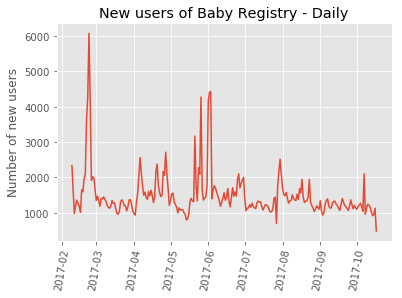

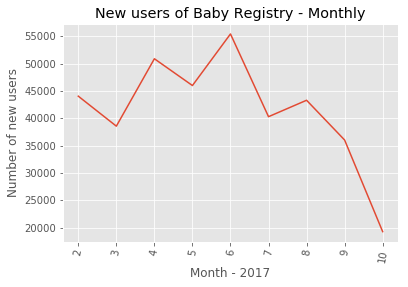

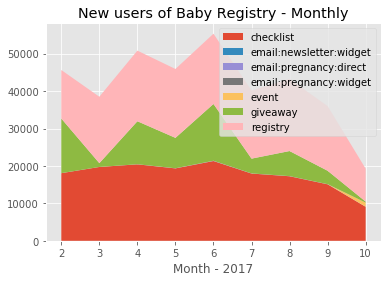

   baby_registry_101_subscribed_at Percentage
0                           398418   39.3595%


In [327]:
report_new_users("baby_registry_101_subscribed_at", "Baby Registry")

## Email List 2 - [newsletter_subscribed_at]

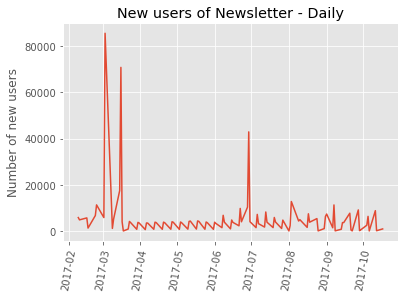

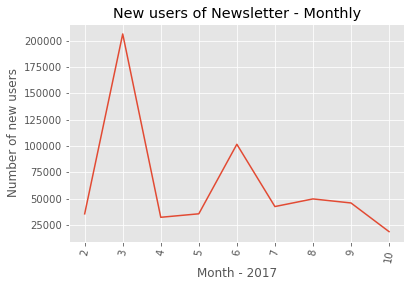

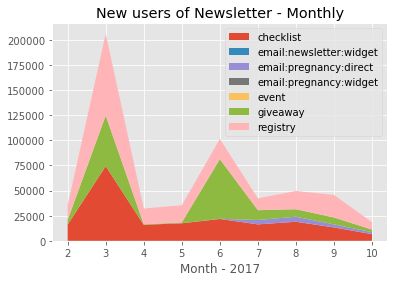

   newsletter_subscribed_at Percentage
0                    757679   74.8508%


In [328]:
report_new_users("newsletter_subscribed_at", "Newsletter")

## Email List 3 - [pregnancy_weekly_subscribed_at]

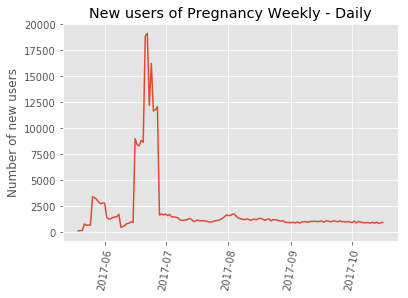

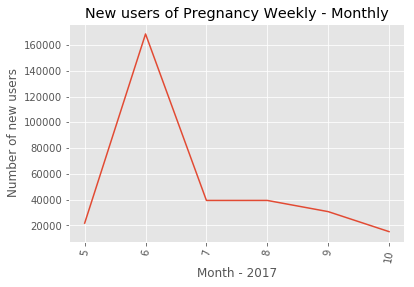

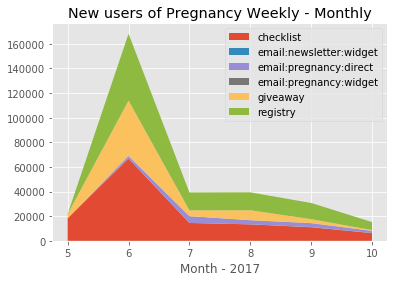

   pregnancy_weekly_subscribed_at Percentage
0                          306336   30.2628%


In [329]:
report_new_users("pregnancy_weekly_subscribed_at", "Pregnancy Weekly")

## Email List 4 - [sponsored_subscribed_at]

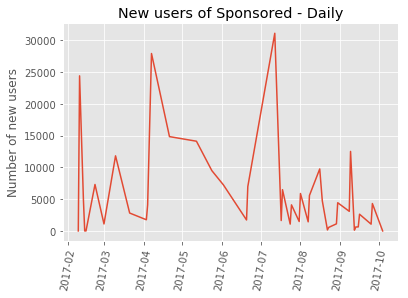

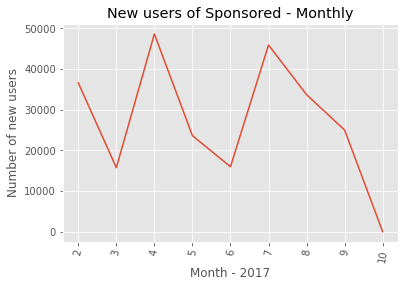

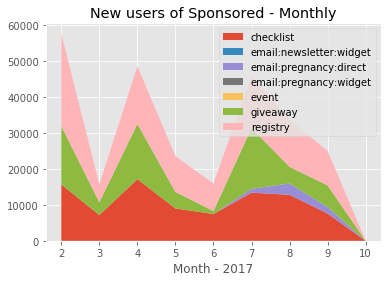

   sponsored_subscribed_at Percentage
0                   487032   48.1137%


In [330]:
report_new_users("sponsored_subscribed_at", "Sponsored")

### Created_at

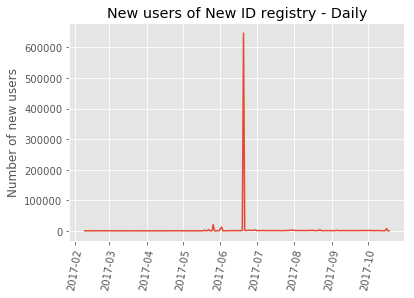

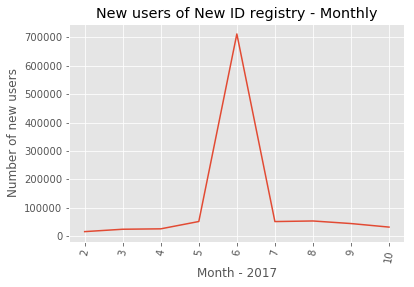

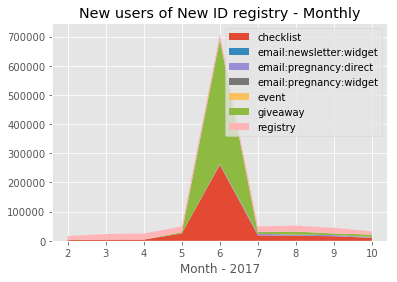

   created_at Percentage
0     1012253  100.0000%


In [331]:
report_new_users("created_at", "New ID registry")

# CHURN

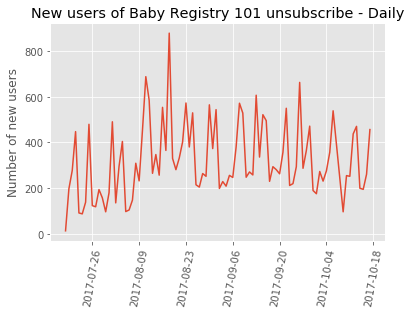

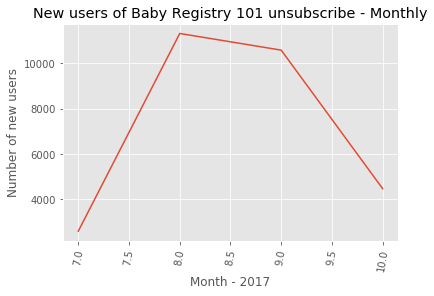

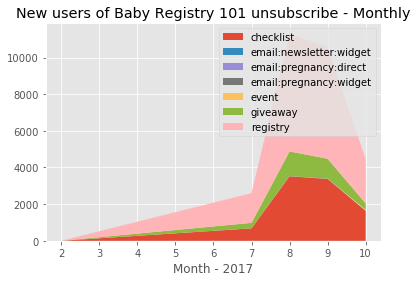

   baby_registry_101_unsubscribe_at Percentage
0                             21124    2.0868%


In [332]:
report_new_users("baby_registry_101_unsubscribe_at", "Baby Registry 101 unsubscribe")

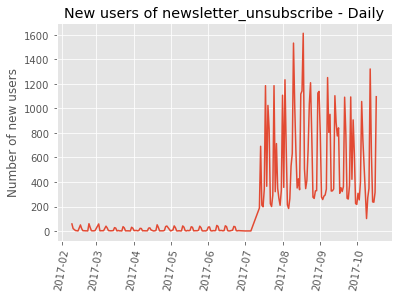

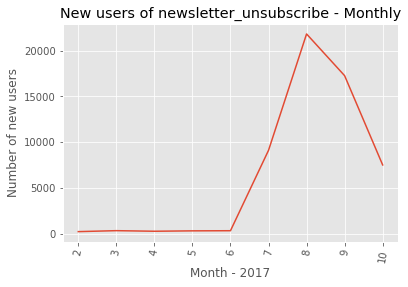

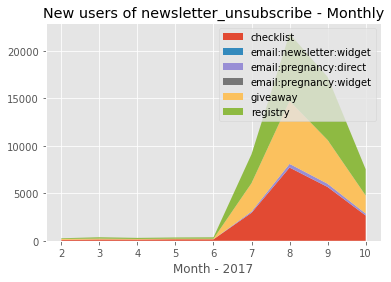

   newsletter_unsubscribe_at Percentage
0                      47974    4.7393%


In [333]:
report_new_users("newsletter_unsubscribe_at", "newsletter_unsubscribe")

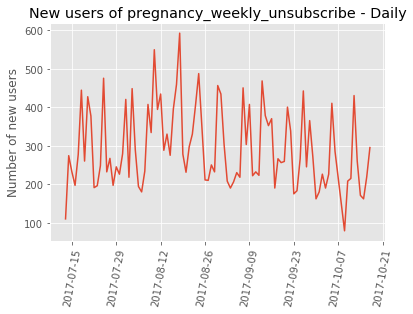

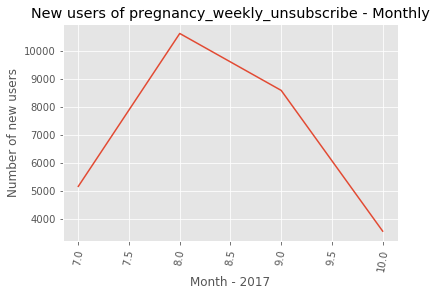

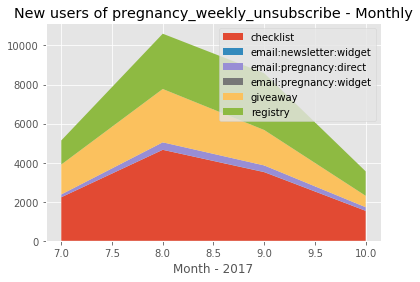

   pregnancy_weekly_unsubscribe_at Percentage
0                            27155    2.6826%


In [334]:
report_new_users("pregnancy_weekly_unsubscribe_at", "pregnancy_weekly_unsubscribe")

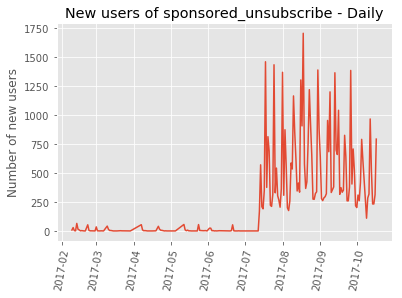

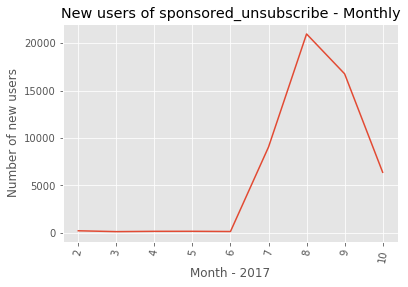

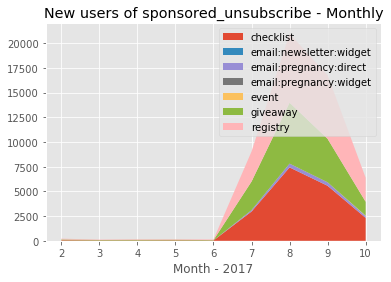

   sponsored_unsubscribe_at Percentage
0                     45246    4.4698%


In [335]:
report_new_users("sponsored_unsubscribe_at", "sponsored_unsubscribe")